In [1]:
import itertools
import json

import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from tqdm import tqdm
# from itertools import chain

from sqr.core.network import partition_surjective
from sqr.core.scoring import partition_score, get_undominated
from sqr.core.shape import  make_gdf_square_data

%matplotlib inline

# Load data 

#### Municipal data 

This data consists of the shape files for municipalities and muncipality data parsed ti have square net information. 

In [2]:
kommuner = gpd.read_file('data/shape/KOMMUNE.shp')

mun_pop = {}
mun_cell_count = {}
for idx in kommuner.index:
    mun_data = \
        pd.read_hdf('data/parsed/sqr_mun.hdf', key='sqidx%i'% idx)
    mun_pop[idx] = mun_data.minimum.sum()    
    mun_cell_count[idx] = mun_data.shape[0]
                
kommuner['minimum_total'] = pd.Series(mun_pop)
kommuner['cell_count'] = pd.Series(mun_cell_count)

kommuner['to_assign'] = kommuner.minimum_total>100

#### Preprocessed data 

This data consists of the output from running 'Step 1: run assignments.'

In [3]:
other = 'data/temp_from_other/'
main = 'data/'
pareto = 'data/pareto/'

othernames = {'candidates_sub.hdf':['candidates_sub_aws.hdf','candidates_sub_mac.hdf','candidates_sub_oko4.hdf'],
              'candidates.hdf':['candidates_aws.hdf']}

filenames = {'candidates.hdf':['pareto.hdf','parsed/sqr_mun.hdf'], 
             'candidates_sub.hdf':['pareto_sub.hdf','parsed/sqr_mun_sub.hdf']}


# Merge and select pareto

Merge other data storages

In [6]:
def attemp_read(in_file, input_key):
    try:
        return pd.read_hdf(in_file, key=input_key)
    except:
        return pd.DataFrame()

In [4]:
# list of files with output
candidate files = 'candidates.hdf', 'candidates_sub.hdf'


#for filename in []:
# for filename in ['candidates.hdf']:
    
    
#     out_file = main+filename
    
#     in_files = [other+f for f in othernames[filename]]
#     input_keys = list(set(chain(*[pd.HDFStore(in_file).keys() for in_file in in_files])))


#     for input_key in input_keys:    
#         in_list = [attemp_read(f, input_key) for f in in_files]    
#         input_df = pd.concat(in_list)
        
#         try:
#             existing = pd.read_hdf(out_file, key=input_key)
#             out = pd\
#                     .concat([input_df, existing])\
#                     .drop_duplicates(subset='finish_ts')
#         except:
#             out = input_df
        
#         out.to_hdf(out_file, key=input_key)

Compute Pareto frontier

In [ ]:
for filename in ['candidates.hdf','candidates_sub.hdf']:
    
    in_file = main+filename
    out_file = main+filenames[filename][0]
    
    for input_key in tqdm(list(pd.HDFStore(in_file).keys())):
        input_df = pd.read_hdf(in_file, key=input_key)
        input_df = input_df.reset_index(drop=True)
        
        if input_df.shape[0]>1:
            out = get_undominated(input_df)
        else:
            out = input_df
        
        out.to_hdf(out_file, key=input_key)

  2%|▏         | 1/63 [00:04<04:15,  4.12s/it]

In [62]:
hdf = pd.HDFStore('data/pareto_sub.hdf')
keys = hdf.keys()

for k in keys:
    if len(k.split('_'))==1:
        hdf.remove(k)
        
hdf.close()        

# Choose best partitions

In [13]:
def chain(l):
    return list(itertools.chain(*l))

Load populations

In [11]:
mun_pop = {}
mun_indices = {}

in_file = main+'candidates_sub.hdf'
mun_file = main+'parsed/sqr_mun_sub.hdf'

for input_key in pd.HDFStore(in_file).keys():
    idx = input_key[7:]
    input_df = pd.read_hdf(in_file, key=input_key)
    mun_df = pd.read_hdf(mun_file, key='sqidx'+idx)

    mun_pop[idx] = mun_df.minimum.sum()
    mun_indices[idx] = mun_df.KN100mDK.to_dict()
    
mun_file = main+'parsed/sqr_mun.hdf'
for input_key in pd.HDFStore(mun_file).keys():
    idx = input_key[6:]
    mun_df = pd.read_hdf(mun_file, key=input_key)
    mun_pop[idx] = mun_df.minimum.sum()
    mun_indices[idx] = mun_df.KN100mDK.to_dict()

Load optimal partition mun-level

In [7]:
in_file = main+'pareto.hdf'
keys = pd.HDFStore(in_file).keys()

pareto = pd.concat([pd.read_hdf(in_file, k) for k in keys]).reset_index()
pareto.mun_idx = pareto.mun_idx.astype(int).astype(str)
pareto['score'] = pareto.apply(lambda row: partition_score(row.weighted_dist, 
                                         row.count_nonzero_null, 
                                         mun_pop[row.mun_idx]),axis=1)
optimals_idx = pareto.groupby('mun_idx').score.idxmax()
optimals = pareto.loc[optimals_idx]
optimals.partition = optimals.partition.apply(json.loads)

Load optimal partition sub mun-level

In [14]:
in_file = main+'pareto_sub.hdf'
keys = pd.HDFStore(in_file).keys()

pareto_sub = pd.concat([pd.read_hdf(in_file, k) for k in keys]).reset_index()
pareto_sub['score'] = pareto_sub\
                        .apply(lambda row: partition_score(row.weighted_dist, 
                                                           row.count_nonzero_null, 
                                                           mun_pop[row.mun_idx]),axis=1)

optimals_idx_sub = pareto_sub.groupby('mun_idx').score.idxmax()

optimals_sub = pareto_sub.loc[optimals_idx_sub.values].copy()
optimals_sub['pop_count'] = optimals_sub.mun_idx.apply(lambda m: mun_pop[m])
optimals_sub['mun'] = optimals_sub.mun_idx.apply(lambda s: s.split('_')[0])
optimals_sub.partition = optimals_sub.partition.apply(json.loads)

# remove køge
# optimals_sub = optimals_sub[~(optimals_sub['mun']=='163')]

gb_idx = optimals_sub.groupby('mun')
pop_sum = gb_idx.pop_count.sum()
na_sum = gb_idx.pop_nonzero_null.sum()
w_dist = gb_idx.apply(lambda g: (g.weighted_dist*g.pop_count).sum()/g.pop_count.sum())
partitions = gb_idx.partition.apply(chain)


optimals_sub_merg = pd.concat([na_sum,
                               pop_sum,
                               w_dist.rename('weighted_dist'),
                               partitions.rename('partition')],axis=1)

optimals_sub_merg['score'] = \
    optimals_sub_merg.apply(lambda row: partition_score(row.weighted_dist, 
                                                    row.pop_nonzero_null, 
                                                    row.pop_count),axis=1)

Comparison of partitions

In [15]:
merge_cols = ['score','partition','pop_nonzero_null','weighted_dist']
opt_mun = optimals.set_index('mun_idx')[merge_cols]
opt_sub = optimals_sub_merg[merge_cols]                              

merge = opt_mun.merge(opt_sub, how='outer', left_index=True,right_index=True).copy()
merge[['score_x','score_y']] = merge[['score_x','score_y']].fillna(-1)

In [16]:
def get_label(mun_idx, idx):
    return mun_indices[mun_idx][idx]

def get_labels(mun_idx, partition):
    return [[get_label(mun_idx,i) for i in g] for g in partition]

Select maximal scoring partitoin

In [34]:
optimal_indices = merge.apply(lambda row: row.partition_x if row.score_x>row.score_y else row.partition_y, axis=1)

optimal_labels =  optimal_indices\
                    .reset_index()\
                    .rename(columns={'index':'mun_idx',0:'partition'})\
                    .apply(lambda row: get_labels(str(row.mun_idx),row.partition),axis=1)

optimal_labels.index = optimal_indices.index.to_series().astype(int)
optimal_labels.sort_index(inplace=True)            
            
optimal_labels_one = list(itertools.chain(*optimal_labels.tolist()))

Output final partition

In [ ]:
with open ('data/output_final/partition.json', 'w') as f:
    f.write(json.dumps(optimal_labels_one))

# Analyze optimal partition

In [91]:
optimal_miss = merge.apply(lambda row: row.pop_nonzero_null_x if row.score_x>row.score_y else row.pop_nonzero_null_y, axis=1)
optimal_dist = merge.apply(lambda row: row.weighted_dist_x if row.score_x>row.score_y else row.weighted_dist_y, axis=1)

optimal_stat = pd\
                .concat([optimal_miss,pd.Series(mun_pop),optimal_dist],axis=1)\
                .dropna()\
                .rename(columns={0:'miss',1:'total',2:'dist'})
            
optimal_stat.index = optimal_stat.index.to_series().astype(int)

optimal_stat.sort_index().to_csv('data/output_final/statistics.csv')

Check no duplicated

In [93]:
is_assigned = list(itertools.chain(*optimal_labels_one))
is_assigned_ser = pd.Series(is_assigned)
is_assigned_ser.duplicated().sum()

0

Count population in partitions

In [94]:
pers = pd.read_hdf('data/parsed/personer_celler.hdf', key='_100m').iloc[1:]

years = list(map(str,range(1986,2016)))
assignment = dict([(i,g_idx) for g_idx,g in enumerate(optimal_labels_one) for i in g])
pers_assign = pers.set_index('ddkncelle100m').join(pd.Series(assignment,name='assignment'))
pers_assign = pers_assign[pers_assign.assignment.notnull()]

g = pers_assign.loc[optimal_labels_one[0]]
distribution = pers_assign\
                .groupby('assignment')\
                .apply(lambda g: g[years].dropna(how='all',axis=1).sum(axis=0).min())

Verify minimum population is 100

In [14]:
distribution.min()

100.0

Make histogram of population sizes in the final partitions

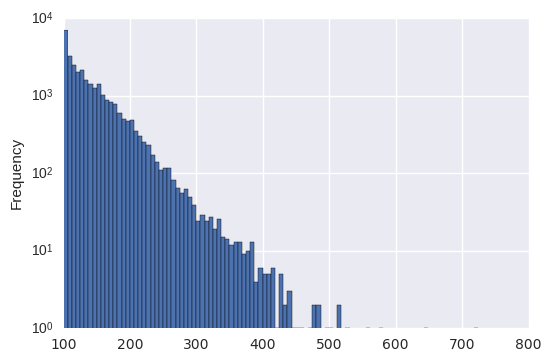

In [104]:
fig = dist.plot.hist(bins=100,log=True)
fig.figure.savefig('Fig/pop_distribution_assignments.pdf')

Count unassigned population for each year

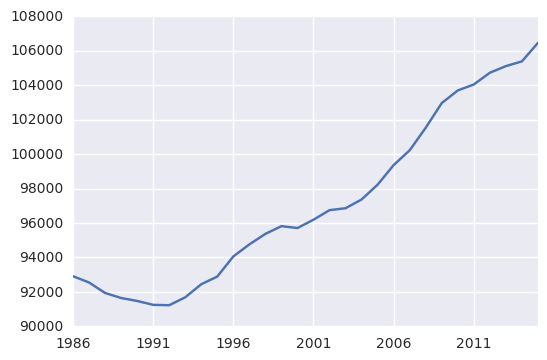

In [121]:
pop_unassigned_years = pers[~pers.ddkncelle100m.isin(is_assigned)][years].fillna(0)
fig = pop_unassigned_years.sum(axis=0).plot()
fig.figure.savefig('Fig/pop_years_cells_unassigned.pdf')

Mean annual cell size for cells not part of a partition

97150.39999999947

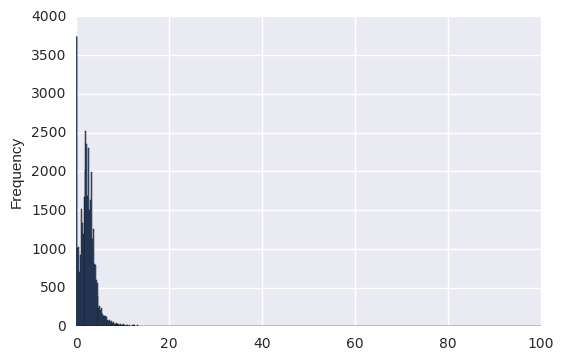

In [116]:
pop_unassigned = pers[~pers.ddkncelle100m.isin(is_assigned)][years].fillna(0).mean(axis=1)
fig = pop_unassigned.plot.hist(bins=500,range=[0,100])
fig.figure.savefig('Fig/pop_distribution_cells_unassigned.pdf')
pop_unassigned.sum()